In [ ]:
!nvidia-smi

Mon Jun 14 21:57:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !spacy download de_core_news_sm -q
# !spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
# %pip install -q wandb

# References
- https://www.tensorflow.org/text/tutorials/transformer
- https://pytorch.org/tutorials/beginner/translation_tansformer.html
- https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
- https://arxiv.org/abs/1706.03762

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import OrderedDict

In [ ]:
plt.rcParams["figure.facecolor"] = "white"

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Position Encoding

$\begin{equation*}\Large
PE_{(pos,2i)} = sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{equation*}$

$\begin{equation*}\Large
PE_{(pos,2i+1)} = cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{equation*}$

In [ ]:
def positional_encoding(max_seq_len, d_model):
    pos = np.arange(max_seq_len)[:, None]   # [max_seq_len, 1]
    i = np.arange(d_model)[None,:]          # [1, d_model]
    angles = (pos / (10_000**(2*i/d_model))).astype(np.float32)
    angles[:,0::2] = np.sin(angles[:,0::2])
    angles[:,1::2] = np.cos(angles[:,1::2])
    return angles[None,:]   # [1, max_seq_len, d_model]

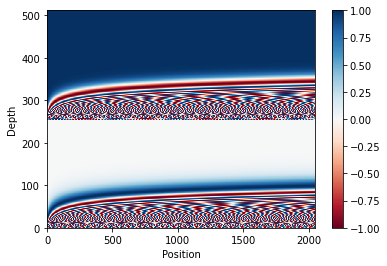

In [ ]:
max_seq_len, d_model = 2048, 512
pe = positional_encoding(max_seq_len, d_model)[0]
pe = pe.reshape(max_seq_len, d_model//2, 2)
pe = pe.transpose(2,1,0)
pe = pe.reshape(d_model, max_seq_len)
plt.pcolormesh(pe, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Multi Headed Scaled Dot Product Attention

![multi_head_attention](https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png)

$\begin{equation*}\Large
Attention(Q,K,V) = softmax\left(\frac{QK^{T}}{\sqrt{d_k}}\right)V
\end{equation*}$

In [ ]:
class mha(nn.Module):  # multi headed attention
    def __init__(self, d_model=512, nheads=8, dp_rate=0.1):
        super().__init__()
        self.nheads = nheads
        self.qw = nn.Linear(d_model, d_model)
        self.kw = nn.Linear(d_model, d_model)
        self.vw = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.depth = d_model//nheads
        self.dropout = nn.Dropout(dp_rate)

    def scaled_dot_product_attention(self, q, k, v, attn_mask=None): # q,k[B, nheads, seq_len, depth]
        scale = q.size(-1)**-0.5
        q = q*scale

        attn = torch.matmul(q, k.transpose(-2,-1)) # [B, nheads, seq_len_q, seq_len_k]
        if attn_mask is not None:
            attn += attn_mask
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)    # [B, nheads, seq_len_q, depth_v]
        return out, attn

    def forward(self, query, key, value, attn_mask=None):   # [B, seq_len, d_model]
        batch_size, seq_len, d_model = query.shape
        q,k,v = self.qw(query), self.kw(key), self.vw(value) # [B, seq_len, d_model]
        
        q = q.view(batch_size, -1, self.nheads, self.depth)     # [B, seq_len_q, nheads, depth]   # d_model = nheads * depth
        k = k.view(batch_size, -1, self.nheads, self.depth)     # [B, seq_len_k, nheads, depth]
        v = v.view(batch_size, -1, self.nheads, self.depth)     # [B, seq_len_v, nheads, depth]
        
        q = q.transpose(-2,-3)  # [B, nheads, seq_len_q, depth]
        k = k.transpose(-2,-3)  # [B, nheads, seq_len_k, depth]
        v = v.transpose(-2,-3)  # [B, nheads, seq_len_v, depth]
        
        out, attn = self.scaled_dot_product_attention(q,k,v,attn_mask)   # [B, nheads, seq_len_q, depth]
        
        out = out.transpose(-2,-3)  # [B, seq_len_q, nheads, depth]
        
        out = out.reshape(batch_size, -1, d_model)  # [B, seq_len_q, d_model]
        out = self.out_proj(out)     # [B, seq_len_q, d_model]
        return out, attn

# Transformer

![Transformer](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

In [ ]:
# just for feed forward network in Encoder and Decoder layers
def get_ffn(d_model, dp_rate=0.1, activation='relu'):
    if activation == 'relu':
        act_lyr = nn.ReLU()
    elif activation == 'gelu':
        act_lyr = nn.GELU()
    return nn.Sequential(OrderedDict([
            ('lin1', nn.Linear(d_model, d_model*4)),
            ('activation', act_lyr),
            ('dropout', nn.Dropout(dp_rate)),
            ('lin2', nn.Linear(d_model*4, d_model))
        ]))

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.attn = mha(d_model=d_model, nheads=nheads, dp_rate=dp_rate)
        self.dropout1 = nn.Dropout(dp_rate)
        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = get_ffn(d_model, dp_rate, activation)
        self.dropout2 = nn.Dropout(dp_rate)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, attn_mask=None):   # [B, seq_len, d_model]
        x = self.ln1(x + self.dropout1(self.attn(x,x,x, attn_mask)[0]))
        x = self.ln2(x + self.dropout2(self.ffn(x)))
        return x

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.attn1 = mha(d_model=d_model, nheads=nheads, dp_rate=dp_rate)
        self.dropout1 = nn.Dropout(dp_rate)
        self.ln1 = nn.LayerNorm(d_model)

        self.attn2 = mha(d_model=d_model, nheads=nheads, dp_rate=dp_rate)
        self.dropout2 = nn.Dropout(dp_rate)
        self.ln2 = nn.LayerNorm(d_model)

        self.ffn = get_ffn(d_model, dp_rate, activation)
        self.dropout3 = nn.Dropout(dp_rate)
        self.ln3 = nn.LayerNorm(d_model)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):   # [B, seq_len, d_model]
        x = self.ln1(x + self.dropout1(self.attn1(x,x,x, tgt_mask)[0]))
        x = self.ln2(x + self.dropout2(self.attn2(x,enc_output,enc_output, src_mask)[0]))
        x = self.ln3(x + self.dropout3(self.ffn(x)))
        return x

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, src_vocab_size, nlayers=6, d_model=512, nheads=8, dp_rate=0.1, activation='relu', use_pe=True):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        self.use_pe = use_pe
        if self.use_pe:
            pos_enc = torch.tensor(positional_encoding(max_seq_len, d_model), requires_grad=False)
            self.register_buffer('pos_enc', pos_enc)
        self.dropout = nn.Dropout(dp_rate)
        self.enc_layers = nn.ModuleList([TransformerEncoderLayer(d_model, nheads, dp_rate, activation)
                                         for _ in range(nlayers)])   # repeat encoder layer N times
    
    def forward(self, x, src_mask=None):   # [B, seq_len]
        seq_len = x.size(1)
        x = self.embedding(x)               # [B, seq_len, d_model]
        x = x * (self.d_model**0.5)
        if self.use_pe:
            x = x + self.pos_enc[:,:seq_len]
        x = self.dropout(x)
        for lyr in self.enc_layers:
            x = lyr(x, src_mask)
        return x

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, tgt_vocab_size, nlayers=6, d_model=512, nheads=8, dp_rate=0.1, activation='relu', use_pe=True):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.use_pe = use_pe
        if self.use_pe:
            pos_enc = torch.tensor(positional_encoding(max_seq_len, d_model), requires_grad=False)
            self.register_buffer('pos_enc', pos_enc)
        self.dropout = nn.Dropout(dp_rate)
        self.dec_layers = nn.ModuleList([TransformerDecoderLayer(d_model, nheads, dp_rate, activation)
                                         for _ in range(nlayers)])   # repeat decoder layer N times
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):   # [B, seq_len]
        seq_len = x.size(1)
        x = self.embedding(x)              # [B, seq_len, d_model]
        x = x * (self.d_model**0.5)
        if self.use_pe:
            x = x + self.pos_enc[:,:seq_len]
        x = self.dropout(x)
        for lyr in self.dec_layers:
            x = lyr(x, enc_output, src_mask, tgt_mask)
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nheads=8,
                 nlayers=6, dp_rate=0.1, activation='relu', use_pe=True):
        super().__init__()
        self.encoder = TransformerEncoder(src_vocab_size, nlayers, d_model, nheads, dp_rate, activation, use_pe)
        self.decoder = TransformerDecoder(tgt_vocab_size, nlayers, d_model, nheads, dp_rate, activation, use_pe)
        self.fout = nn.Linear(d_model, tgt_vocab_size)
        self.reset_parameters()

    def reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):   # [B, seq_len]
        x = self.encoder(src, src_mask)
        x = self.decoder(tgt, x, src_mask, tgt_mask)
        x = self.fout(x)
        return x

# Dataset

In [ ]:
import torchtext
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

from collections import Counter
from itertools import chain
import io

In [ ]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

In [ ]:
train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

In [ ]:
train_filepaths

['/content/.data/train.de', '/content/.data/train.en']

In [ ]:
de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [ ]:
def build_vocab(filepath, tokenizer):
    with io.open(filepath, encoding="utf8") as f:
        lines = ''.join(f.readlines()).replace('\n', ' ')
        counter = Counter(tokenizer(lines))
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

In [ ]:
de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

In [ ]:
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

In [ ]:
def split_toks(toks, sep='\n'):         # tokenizing line by line was too slow on colab.
    chunk = []
    for v in toks:
        if sep in v:
            yield chunk
            chunk = []
        else:
            chunk.append(v)

In [ ]:
def data_preprocess(filepaths):
    with io.open(filepaths[0], encoding="utf8") as f:
        de_full = ' '.join(f.readlines())
    with io.open(filepaths[1], encoding="utf8") as f:
        en_full = ' '.join(f.readlines())
    de_toks = de_tokenizer(de_full)
    en_toks = en_tokenizer(en_full)
    de_iter = split_toks(de_toks)
    en_iter = split_toks(en_toks)
    data = []
    for de_line, en_line in zip(de_iter, en_iter):
        de_tensor = torch.tensor([BOS_IDX] + 
                                 [de_vocab[token] for token in de_line] + 
                                 [EOS_IDX])
        en_tensor = torch.tensor([BOS_IDX] + 
                                 [en_vocab[token] for token in en_line] + 
                                 [EOS_IDX])
        data.append((de_tensor, en_tensor))
    return data

In [ ]:
train_data = data_preprocess(train_filepaths)
val_data = data_preprocess(val_filepaths)
test_data = data_preprocess(test_filepaths)

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [ ]:
def generate_batch(data_batch):
    de_batch, en_batch = [], []
    for (de_item, en_item) in data_batch:
        de_batch.append(de_item)
        en_batch.append(en_item)
    de_batch = pad_sequence(de_batch, batch_first=True, padding_value=PAD_IDX)
    en_batch = pad_sequence(en_batch, batch_first=True, padding_value=PAD_IDX)
    return de_batch, en_batch

In [ ]:
BATCH_SIZE = 256

In [ ]:
train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch, num_workers=2)
valid_iter = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch, num_workers=2)
test_iter  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch, num_workers=2)

# Masking

In [ ]:
def subsequent_mask(sz):
    mask = torch.ones((1,1,sz,sz), device=device, dtype=bool).tril()
    mask.logical_not_()
    return mask

def mask_fill_inf(mask):
    return mask.float().masked_fill(mask, float('-inf'))

def create_mask(src, tgt):    # [B, seq_len]
    tgt_mask = subsequent_mask(tgt.size(1))
    
    src_padding_mask = (src == PAD_IDX)[:,None,None,:]    # [B, nheads, seq_len_q, seq_len_k]
    tgt_padding_mask = (tgt == PAD_IDX)[:,None,None,:]    # [B, nheads, seq_len_q, seq_len_k]
    tgt_mask = tgt_mask.logical_or(tgt_padding_mask)      # combine mask for look ahead and tgt padding.
    return mask_fill_inf(src_padding_mask), mask_fill_inf(tgt_mask)

# Model Parameters

In [ ]:
import wandb

In [ ]:
config_defaults = {
    'src_vocab_size'    : len(de_vocab),
    'tgt_vocab_size'    : len(en_vocab),
    'BATCH_SIZE'        : BATCH_SIZE,
    'd_model'           : 512,
    'nheads'            : 16,
    'nlayers'           : 4,
    'dp_rate'           : 0.1,
    'activation'        : 'gelu',
    'ilr'               : 1,
    'betas'             : (0.9, 0.98),
    'eps'               : 1e-9,
    'use_amp'           : True,
    'use_pe'            : True,
    'log_interval'      : 5,
}

In [ ]:
# run = wandb.init(id='352vnm9l', project="Basic_Transformer", resume='must')
# CONFIG = run.config

In [ ]:
run = wandb.init(project="Basic_Transformer", entity="shivamshrirao", config=config_defaults)
CONFIG = wandb.config

In [ ]:
model = Transformer(src_vocab_size = CONFIG['src_vocab_size'],
                    tgt_vocab_size = CONFIG['tgt_vocab_size'],
                    d_model = CONFIG['d_model'],
                    nheads = CONFIG['nheads'],
                    nlayers = CONFIG['nlayers'],
                    dp_rate = CONFIG['dp_rate'],
                    activation = CONFIG['activation'],
                    use_pe = CONFIG['use_pe']).to(device)

In [ ]:
def lr_schedule(step, d_model=1024*8, warmup_steps=400):
    # return 1
    step = max(1,step)
    arg1 = step ** -0.5
    arg2 = step * (warmup_steps ** -1.5)
    return (d_model ** -0.5) * min(arg1, arg2)

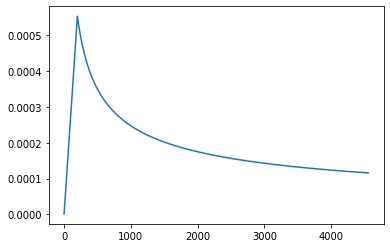

In [ ]:
plt.plot(list(map(lr_schedule, range(114*40))))
plt.show()

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    model.parameters(), lr=CONFIG['ilr'], betas=CONFIG['betas'], eps=CONFIG['eps']
)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)

scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
writer = SummaryWriter(run.dir+'/tensorboard_logs/custom_transformer')

In [ ]:
src, tgt = next(iter(train_iter))
src = src.to(device)
tgt = tgt.to(device)
writer.add_graph(model, (src, tgt))
writer.close()
del src, tgt

In [ ]:
wandb.watch(model, log=None)

In [ ]:
def train_epoch(model, train_iter, optimizer, scaler, scheduler, epoch=1, use_amp=True, log_interval=10):
    model.train()
    losses = 0
    with tqdm(enumerate(train_iter), total=len(train_iter), desc=f"Epoch {epoch}") as pbar:
        for idx, (src, tgt) in pbar:
            src = src.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:,:-1]      # give input until before the last word.
            tgt_out = tgt[:,1:]       # predict the last word based on input and already predicted sentence. (auto-regressive)

            src_mask, tgt_mask = create_mask(src, tgt_inp)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(src, tgt_inp, src_mask, tgt_mask)
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            losses+= loss.item()
            avg_loss = losses/(idx+1)
            curr_lr = optimizer.param_groups[0]['lr']
            if not idx%log_interval:
                wandb.log({'loss': avg_loss, 'lr': curr_lr})
            pbar.set_postfix({'loss': f'{avg_loss:.3f}', 'lr': curr_lr})
    return losses/len(train_iter)

In [ ]:
def evaluate(model, val_iter):
    model.eval()
    losses = 0
    with tqdm(enumerate(val_iter), total=len(val_iter), desc="Evaluating") as pbar:
        for idx, (src, tgt) in pbar:
            src = src.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:,:-1]      # give input until before the last word.
            tgt_out = tgt[:,1:]       # predict the last word based on input and already predicted sentence. (auto-regressive)

            src_mask, tgt_mask = create_mask(src, tgt_inp)

            logits = model(src, tgt_inp, src_mask, tgt_mask)

            loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            losses+= loss.item()
            pbar.set_postfix({'val_loss': f"{losses/(idx+1):.3f}"})
    return losses/len(val_iter)

In [ ]:
init_epoch = 1

In [ ]:
def save_model(model, optimizer, epoch):
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                }, run.dir + '/model.pth')

In [ ]:
# save_model(model, optimizer, init_epoch)

In [ ]:
# wandb.save("*.pth")

In [ ]:
# checkpoint = torch.load(run.dir + '/model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# init_epoch = checkpoint['epoch']

In [ ]:
NUM_EPOCHS = 20

In [ ]:
for epoch in range(init_epoch, NUM_EPOCHS+1):
    train_loss = train_epoch(model, train_iter, optimizer, scaler, scheduler,
                             epoch, CONFIG['use_amp'], CONFIG['log_interval'])
    val_loss = evaluate(model, valid_iter)
    wandb.log({"val_loss": val_loss, "epoch": epoch})
    print(f"Epoch: {epoch}/{NUM_EPOCHS}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}\n")
    # if not epoch%10:
    #     save_model(model, optimizer, epoch)


Epoch: 1/20, Train loss: 6.648, Val loss: 4.863




Epoch: 2/20, Train loss: 4.237, Val loss: 3.710




Epoch: 3/20, Train loss: 3.467, Val loss: 3.264




Epoch: 4/20, Train loss: 3.065, Val loss: 3.003




Epoch: 5/20, Train loss: 2.785, Val loss: 2.862




Epoch: 6/20, Train loss: 2.569, Val loss: 2.742




Epoch: 7/20, Train loss: 2.392, Val loss: 2.657




Epoch: 8/20, Train loss: 2.241, Val loss: 2.606




Epoch: 9/20, Train loss: 2.112, Val loss: 2.557




Epoch: 10/20, Train loss: 1.992, Val loss: 2.539




Epoch: 11/20, Train loss: 1.885, Val loss: 2.505




Epoch: 12/20, Train loss: 1.789, Val loss: 2.484




Epoch: 13/20, Train loss: 1.695, Val loss: 2.455




Epoch: 14/20, Train loss: 1.611, Val loss: 2.463




Epoch: 15/20, Train loss: 1.536, Val loss: 2.433




Epoch: 16/20, Train loss: 1.460, Val loss: 2.434




Epoch: 17/20, Train loss: 1.391, Val loss: 2.427




Epoch: 18/20, Train loss: 1.324, Val loss: 2.442




Epoch: 19/20, Train loss: 1.265, Val loss: 2.435




Epoch: 20/20, Train loss: 1.202, Val loss: 2.442



In [ ]:
init_epoch = epoch

# Make Predictions

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    model.eval()
    src = src.to(device)
    src_mask = src_mask.to(device)
    enc_output = model.encoder(src, src_mask)
    tgt = torch.LongTensor([start_symbol]).reshape(1,-1).to(device)
    for i in range(max_len):
        tgt_mask = mask_fill_inf(subsequent_mask(tgt.size(1)))
        out = model.decoder(tgt, enc_output, src_mask, tgt_mask)
        prob = model.fout(out[:,-1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        tgt = torch.cat([tgt, torch.LongTensor([next_word]).reshape(1,-1).to(device)], dim=1)
        if next_word == EOS_IDX:
            break
    return tgt

def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
    tokens = [BOS_IDX] + [src_vocab[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
    src = torch.LongTensor(tokens).reshape(1,-1)
    src_mask = torch.zeros_like(src).float()[:,None,None,:]
    tgt = greedy_decode(model, src, src_mask, max_len=len(tokens)+10, start_symbol=BOS_IDX).flatten()
    return " ".join([tgt_vocab.itos[tok] for tok in tgt]).replace("<bos>", "").replace("<eos>", "")

In [ ]:
translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .", de_vocab, en_vocab, de_tokenizer)

' A group of people in front of an igloo '

In [ ]:
run.finish()

loss,1.20159
lr,0.00016
_runtime,872
_timestamp,1623712371
_step,479
val_loss,2.44236
epoch,20


loss,█▇▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▃▅██▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
